In [2]:
# TODO


In [3]:
# Code associated with Sauthoff and others, 2023, Journal
# Methods and data exploration notebook to delineate Antarctic
# active subglacial lakes using variable outlines based on 
# ice surface height deformation contours, visualize and quantify 
# lake-averaged da/dt, dh/dt and dv/dt. 
#
# Written 2023-05-15 by W. Sauthoff (wsauthoff.github.io)

In [11]:
# Import internal packages
import os

# Import external packages
import datetime
import geopandas as gpd
import math
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import animation
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import rioxarray
from skimage import measure
import time

# make matplotlib interactive
%matplotlib inline
# %matplotlib notebook

# Define data directories dependent on home environment (replace with your data directory file path(s))
if os.getenv('HOME') == '/home/jovyan':
    DATA_DIR = '/home/jovyan/data_dir'
    SCRIPT_DIR = '/home/jovyan/repos_my/script_dir'
    OUTPUT_DIR = '/home/jovyan/1_outlines_candidates/output/'
elif os.getenv('HOME') == '/Users/Wilson': 
    DATA_DIR = '/Volumes/ExtremeSSD/data'
    SCRIPT_DIR = '/Users/Wilson/Documents/0-code/repos_my/script_dir'
    OUTPUT_DIR = '/Users/Wilson/Documents/0-code/1_outlines_candidates/output'

# Define utility function
def datetime2fracyear(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length

In [12]:
# TODO
# Import CryoTEMPO EOLIS SWATH THEMATIC GRIDDED PRODUCT
# https://cryotempo-eolis.org/gridded-product/

In [13]:
# TODO: Grab ATL15 data using earthaccess or icepyx

# Import ICESat-2 ATL15 Gridded Antarctic and Arctic Land Ice Height Change data product 
# https://doi.org/10.5067/ATLAS/ATL15.002
if os.getenv('HOME') == '/home/jovyan':
    # s3url = 's3://nsidc-cumulus-prod-protected/ATLAS/ATL15/002/2019/ATL15_GL_0314_01km_002_01.nc'
    # FIXME: temporary workaround
    os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'
    granule = 's3://is2view/ATLAS/ATL15/002/2019/ATL15_AA_0314_01km_002_02.nc'
    group = 'delta_h'
    ATL15_dh = rioxarray.open_rasterio(granule, group=group, masked=True)
    # Add Title attribute to dataset
    ATL15_dh.attrs['Title'] = 'IS2'
    # Display xarray dataset metadata
    ATL15_dh
    
elif os.getenv('HOME') == '/Users/Wilson': 
    file = DATA_DIR + '/altimetry/ICESat2/ATL15.002-Ant/ATL15_AA_0314_01km_002_02.nc'
    ATL15_dh = rioxarray.open_rasterio(file, group='delta_h', masked=True)
    # Add Title attribute to dataset
    ATL15_dh.attrs['Title'] = 'IS2'
    # Display xarray dataset metadata
    ATL15_dh

In [14]:
# Scripps Grounding Line
# https://doi.pangaea.de/10.1594/PANGAEA.819147
Scripps_gl = gpd.read_file(DATA_DIR + '/boundaries/Depoorter2013-boundaries/scripps_antarctica_polygons_v1.shp')
# Isolate only land ice
Scripps_landice = Scripps_gl[Scripps_gl['Id_text'] == 'Grounded ice or land']

In [15]:
# MEaSUREs Antarctic Boundaries for IPY 2007-2009 from Satellite Radar, Version 2 (NSIDC-0709)
# https://doi.org/10.5067/AXE4121732AD
# https://nsidc.org/sites/default/files/nsidc-0709-v002-userguide.pdf
IMBIE_basins = gpd.read_file(DATA_DIR + '/boundaries/MEaSUREs-Antarctic-Boundaries/Basins_IMBIE_Antarctica_v02.shp')
refined_basins = gpd.read_file(DATA_DIR + '/boundaries/MEaSUREs-Antarctic-Boundaries/Basins_Antarctica_v02.shp')
ice_boundaries = gpd.read_file(DATA_DIR + '/boundaries/MEaSUREs-Antarctic-Boundaries/IceBoundaries_Antarctica_v02.shp')
grounded_ice_boundaries = ice_boundaries[ice_boundaries["TYPE"]=='GR']

In [16]:
# Import MODIS MOA 2009 and 2014 coastline and grounding line for plotting inset maps
# https://nsidc.org/data/nsidc-0593/versions/1
shp = DATA_DIR + '/boundaries/MODIS-MOA/2009/moa_2009_coastline_v02.0.shp' 
moa_2009_coastline = gpd.read_file(shp)
shp = DATA_DIR + '/boundaries/MODIS-MOA/2009/moa_2009_groundingline_v02.0.shp' 
moa_2009_groundingline = gpd.read_file(shp)
# https://nsidc.org/data/nsidc-0730/versions/1
shp = DATA_DIR + '/boundaries/MODIS-MOA/2014/moa2014_coastline_v01.shp' 
moa_2014_coastline = gpd.read_file(shp)
shp = DATA_DIR + '/boundaries/MODIS-MOA/2014/moa2014_grounding_line_v01.shp' 
moa_2014_groundingline = gpd.read_file(shp)

In [17]:
# Import subglacial lake outline inventories
exec(open(SCRIPT_DIR + '/Smith2009_outlines.py').read())
exec(open(SCRIPT_DIR + '/SiegfriedFricker2018_outlines.py').read())
exec(open(SCRIPT_DIR + '/Sauthoff2023_outlines.py').read())

In [18]:
# MODIS Mosaic of Antarctica surface imagery
# https://nsidc.org/data/nsidc-0730/versions/1
moa_highres = DATA_DIR + '/surface_imagery/MODIS_MOA/2014/moa125_2014_hp1_v01.tif' 

# Open into an xarray.DataArray
moa_da = rioxarray.open_rasterio(moa_highres)
moa_ds = moa_da.to_dataset('band')
moa_da

Warning 1: TIFFReadDirectory:Invalid data type for tag StripByteCounts
Warning 1: TIFFFetchNormalTag:Incorrect value for "GeoKeyDirectory"; tag ignored
Warning 1: TIFFFetchNormalTag:ASCII value for tag "GeoASCIIParams" contains null byte in value; value incorrectly truncated during reading due to implementation limitations


<xarray.DataArray (band: 1, y: 41779, x: 48333)>
[2019304407 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -3.174e+06 -3.174e+06 ... 2.867e+06 2.867e+06
  * y            (y) float64 2.406e+06 2.406e+06 ... -2.816e+06 -2.816e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [19]:
# Clip altimetry datasets to grounding line to not view ice shelf processes
# CryoSat-2 CryoTEMPO EOLIS SWATH THEMATIC GRIDDED PRODUCT

# ICESat-2 ATL15
# Clip ATL15_dh to grounding line (first set crs)
#ATL15_dh.rio.write_crs(3031, inplace=True)
ATL15_dh_clipped = ATL15_dh.rio.clip(Scripps_landice.geometry.values, Scripps_landice.crs, drop=False)

# Clip altimetry datasets to inland to not view coastal processes

In [ ]:
# Plot published lakes with MOA surface imagery and IMBIE and refined basins

# Create figure
fig, ax = plt.subplots(figsize=(50,50))

# Create fig bounds 
x_min=moa_da['x'].min().values
x_max=moa_da['x'].max().values
y_min=moa_da['y'].min().values
y_max=moa_da['y'].max().values
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

# Plot MOA imagery  
ax.imshow(moa_da[0,:,:], cmap="gray", clim=[14000, 17000], extent=[x_min, x_max, y_min, y_max])

# Overlay published lake outlines
Smith2009_outlines.boundary.plot(ax=ax, edgecolor='aqua', facecolor='aqua', linestyle=(0, (1, 5)), linewidth=1, alpha=0.5)
SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor='darkturquoise', facecolor='darkturquoise', linestyle=(0, (1, 1)), linewidth=1, alpha=0.5)
Sauthoff2023_S23outlines.plot(ax=ax, edgecolor='darkcyan', facecolor='darkcyan', linestyle=(0, (1, 1)), linewidth=1, alpha=0.5)

# Overlay IMBIE and refined basins
refined_basins.boundary.plot(ax=ax, edgecolor='gray', linewidth=1)
IMBIE_basins.boundary.plot(ax=ax, edgecolor='w', linewidth=1)

plt.savefig(OUTPUT_DIR + '/Sauthoff2023_methods_data_exploration/MOA_lakes_basins_inlandbuffers2.png')
plt.close()

In [20]:
def S09SF18S23_agg_moa_plot(x_min, x_max, y_min, y_max, region_name, thres, dataset): 
    '''
    Create planview plot of an aggregated times series of variable outlines compared to known lakes over MODIS MOA surface imagery.
    Create time-variable outlines using skimage contour to plot variable outline alongside published outlines for comparison. 
    Inputs: 
        x,y min, max coords: x,y min, max of desired bounding box
        region_name: what to include in output filename
        thres(hold): vertical distance in meters to delineate ice surface deformation contour
        dataset: dataset to be analyzed (CS2_dh or ATL15_dh)
    Outputs: 
        Aggregated time-variable lake outlines using CryoSat-2 or ICESat-2 ATL15 dh/dt data.
    '''
    # Subset dataset and MOA imagery to region of interest using data masks
    mask_x = (dataset.x >= x_min) & (dataset.x <= x_max)
    mask_y = (dataset.y >= y_min) & (dataset.y <= y_max)
    ds_sub = dataset.where(mask_x & mask_y, drop=True)
    mask_x = (moa_da.x >= x_min) & (moa_da.x <= x_max)
    mask_y = (moa_da.y >= y_min) & (moa_da.y <= y_max)
    moa_da_sub = moa_da.where(mask_x & mask_y, drop=True)
    
    # Create empty list to store dates
    dates = []
    
    # Create figure
    fig, ax = plt.subplots(figsize=(20,20))#40,40))
    
    # Cick colormap and norm to time variable
    cmap = plt.get_cmap('CMRmap')
    norm = plt.Normalize(ds_sub.time.values[0],ds_sub.time.values[-1])  
    
    # Plot MOA imagery  
    ax.imshow(moa_da_sub[0,:,:], cmap="gray", clim=[14000, 17000], extent=[x_min, x_max, y_min, y_max])
    
    # Overlay published outlines for visual comparison 
    Smith2009_outlines.boundary.plot(ax=ax, edgecolor='aqua', facecolor='aqua', linestyle=(0, (1, 5)), linewidth=1, alpha=0.5)
    SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor='darkturquoise', facecolor='darkturquoise', linestyle=(0, (1, 1)), linewidth=1, alpha=0.5)
    Sauthoff2023_S23outlines.boundary.plot(ax=ax, edgecolor='darkcyan', facecolor='darkcyan', linestyle=(0, (1, 1)), linewidth=1, alpha=0.5)
    Scripps_gl.boundary.plot(ax=ax, edgecolor='w', linewidth=0.75)
   
    # For loop through time variable which are aquisition cycles of altimetry instrument
    for idx in range(len(ds_sub.time)-1): 
        # Calculate dhdt diff between aquisition cycles of delta_h
        dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
        # Calculate mid-cycle dates for plotting
        if dataset.fileName == 'mos_2010.5_2021.5.h5':
            newdate = datetime.datetime(int(ds_sub.time.values[idx]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx] % 1) * 365.25)
            newdate1 = datetime.datetime(int(ds_sub.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx+1] % 1) * 365.25)
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
            date_time_str = '18-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx])
            newdate1 = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx+1])
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        
        # Create empty lists to store contour data    
        contours_fill = []
        contours_drain = []
        
        # Create contours of ice surface elevation height changes to delineate variable lake outlines   
        contour = measure.find_contours(dhdt.values, thres)
        if len(contour) > 0: 
            contours_fill += [contour]
        contour = measure.find_contours(dhdt.values, -thres)
        if len(contour) > 0: 
            contours_drain += [contour]
        
        # Create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt.shape[1]
        y_conv = (y_max-y_min)/dhdt.shape[0]
        
        # Plot variable outlines found in this time slice
        for i in range(len(contours_fill)): 
            for j in range(len(contours_fill[i])):
                ax.plot(x_min+contours_fill[i][j][:, 1]*x_conv, y_max-contours_fill[i][j][:, 0]*y_conv, 
                color=cmap(norm(ds_sub.time.values[idx])), linestyle=(0, (3, 1, 1, 1)), linewidth=0.25)
                # TODO: add creation of polygons when you've selected threshold method
        for i in range(len(contours_drain)): 
            for j in range(len(contours_drain[i])):
                ax.plot(x_min+contours_drain[i][j][:, 1]*x_conv, y_max-contours_drain[i][j][:, 0]*y_conv, 
                color=cmap(norm(ds_sub.time.values[idx])), linestyle=(0, (5, 1)), linewidth=0.25)
                # TODO: add creation of polygons when you've selected threshold method
    
    # Set axes limits
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
    
    # Change polar stereographic m to km for cleaner-looking axes labels
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.yaxis.set_major_formatter(ticks_y)
    
    # Label axes
    ax.set_xlabel('x [km]', size=15)
    ax.set_ylabel('y [km]', size=15)
    
    # Create colorbar for time variable
    m = plt.cm.ScalarMappable(cmap=cmap)
    m.set_array(np.array([datetime2fracyear(date) for date in dates[0:-1]]))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='2.5%', pad=0.7)
    if dataset.Title == 'CS2':
        fig.colorbar(m,  cax=cax, orientation='horizontal').set_label('Year', size=15)
    elif dataset.Title == 'IS2':    
        fig.colorbar(m,  cax=cax, orientation='horizontal', ticks=np.array([2019,2020,2021])).set_label('Year', size=15)
   
    # Create lines for legend
    Smith2009 = plt.Line2D((0, 1), (0, 0), color='aqua', linestyle=(0, (1, 1)), linewidth=2)
    SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='darkturquoise', linestyle=(0, (1, 5)), linewidth=2)
    Sauthoff2023 = plt.Line2D((0, 1), (0, 0), color='darkcyan', linestyle=(0, (1, 10)), linewidth=2)
    uplift = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
    subsidence = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (5, 1)), linewidth=1)
    gl = plt.Line2D((0, 1), (0, 0), color='w', linestyle='-', linewidth=2)

    # Overlay IMBIE and refined basins
    refined_basins.boundary.plot(ax=ax, edgecolor='gray', linewidth=1)
    IMBIE_basins.boundary.plot(ax=ax, edgecolor='white', linewidth=1)

    # Plot inland buffers of grounding line that could serve as clips for ATL15
    Scripps_landice_buffer5km = Scripps_landice.geometry.buffer(-3000)
    Scripps_landice_buffer5km.boundary.plot(ax=ax, ec='red', linewidth=0.75)
    
    # Create legend
    ax.legend([Smith2009, SiegfriedFricker2018, Sauthoff2023, uplift, subsidence, gl],
        ['Smith and others, 2009 static outline', 'Siegfried & Fricker, 2018 static outline', 'Newer lake points',
        ('+'+str(thres)+' m uplift (filling) variable outline'), '–'+str(thres)+' m subsidence (draining) variable outline', 'grounding line'], 
        loc='upper left')
    
    # Plot inset map to show location 
    axIns = ax.inset_axes([0.01, 0.01, 0.25, 0.25]) # [left, bottom, width, height] (fractional axes coordinates)
    axIns.set_aspect('equal')
    moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
    moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
    rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='k', zorder=3)
    axIns.add_artist(rect) 
    axIns.axis('off')
    
    # Save and close figure
    # plt.savefig(OUTPUT_DIR + '/Sauthoff2023_methods_data_exploration/S09SF18S23_agg_moa_plot/regions/S09SF18S23_agg_moa_plot-{}-{}-thres{}m.png'.format(region_name,dataset.Title,thres), dpi=300, bbox_inches = "tight")
    # plt.close()
    plt.show()

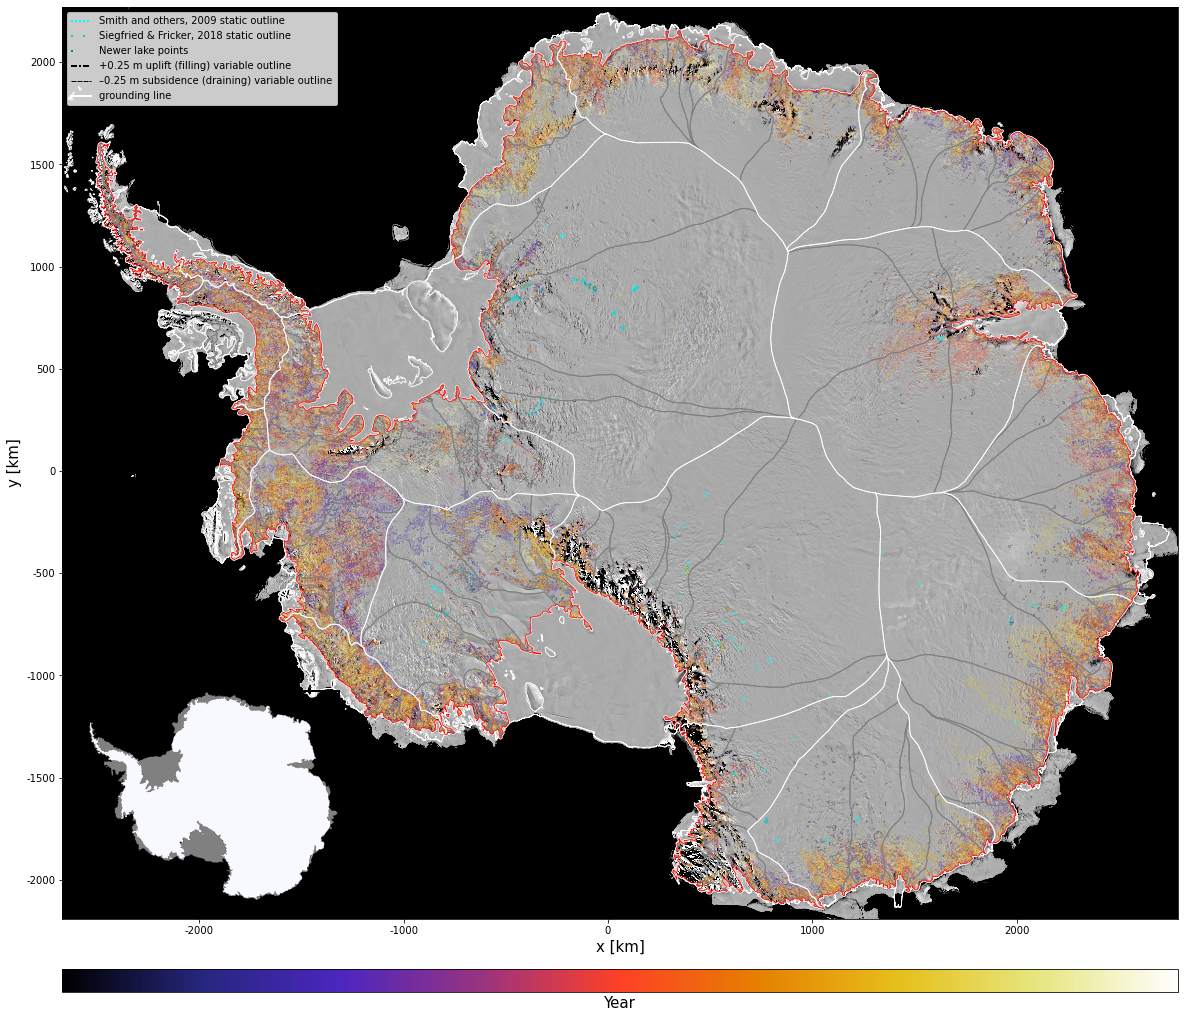

In [21]:
# Define bounding box
# Run function to plot regional plot of variable outlines

# Ensure x, y min, max are ordered correctly
# print(x_min)
# print(x_max)
# print(y_min)
# print(y_max)

# Lower Slessor Glacier
# lon_min=-39
# lon_max=-20
# lat_min=-80.4
# lat_max=-79.5
# x_min = ll2ps(lon_min,lat_min)[0]
# x_max = ll2ps(lon_max,lat_max)[0]
# y_min = ll2ps(lon_min,lat_min)[1]
# y_max = ll2ps(lon_max,lat_max)[1]
# S09SF18S23_agg_moa_plot(x_min, x_max, y_min, y_max, 'LowerSlessor', 0.5, CS2_dh)
# S09SF18S23_agg_moa_plot(x_min, x_max, y_min, y_max, 'LowerSlessor', 2.0, ATL15_dh)

# Antarctica
# x_min=moa_da['x'].min().values
# x_max=moa_da['x'].max().values
# y_min=moa_da['y'].min().values
# y_max=moa_da['y'].max().values
x_min=ATL15_dh['x'].min().values
x_max=ATL15_dh['x'].max().values
y_min=ATL15_dh['y'].min().values
y_max=ATL15_dh['y'].max().values
# S09SF18S23_agg_moa_plot(x_min, x_max, y_min, y_max, 'Antarctica', 0.5, CS2_dh)
# S09SF18S23_agg_moa_plot(x_min, x_max, y_min, y_max, 'Antarctica', 2.0, ATL15_dh_clipped)
# S09SF18S23_agg_moa_plot(x_min, x_max, y_min, y_max, 'Antarctica', 1.75, ATL15_dh_clipped)
# S09SF18S23_agg_moa_plot(x_min, x_max, y_min, y_max, 'Antarctica', 1.5, ATL15_dh_clipped)
# S09SF18S23_agg_moa_plot(x_min, x_max, y_min, y_max, 'Antarctica', 1.25, ATL15_dh_clipped)
# S09SF18S23_agg_moa_plot(x_min, x_max, y_min, y_max, 'Antarctica', 1.0, ATL15_dh_clipped)
# S09SF18S23_agg_moa_plot(x_min, x_max, y_min, y_max, 'Antarctica', 0.75, ATL15_dh_clipped)
# S09SF18S23_agg_moa_plot(x_min, x_max, y_min, y_max, 'Antarctica', 0.5, ATL15_dh_clipped)
S09SF18S23_agg_moa_plot(x_min, x_max, y_min, y_max, 'Antarctica', 0.25, ATL15_dh_clipped)